In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
from langdetect import detect

pd.set_option("display.max_rows" , 500)
pd.set_option("display.max_columns" , 500)

#load csv file

PATH = "F:\Work\OpenClassroomML\Projet5\data"

rawdf = pd.read_csv(os.path.join(PATH, "QueryResults.csv"),
                         encoding = 'utf8',
                         sep = ',',
                         low_memory = False)




In [2]:
def tag_cleaner(html):
    """Function to remove html tags on tags"""
    # parse html content
    soup = BeautifulSoup(html, "lxml")
    codetoremove = soup.findAll("code")
 
    for code in codetoremove:
        code.replace_with("")
         
    # return data by retrieving the tag content
    return str(soup)



def tag_tokenizer(tags) :
    """Tokenize and clean tags"""
    tags_clean = tags.replace('><', ' ').replace('<', '').replace('>', '')
    tags_tokens = word_tokenize(tags_clean)
    return tags_tokens


def tokenizer_fct(sentence) :
    """Tokenize sentence"""
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('\n', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')',"n't"]

def stop_word_filter_fct(list_words) :
    """Remove stop words of list"""
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

def lower_start_fct(list_words) :
    """Lowercase words, spare URL and email adresses"""
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def get_wordnet_pos_list(list_words):
    """Map POS tag to first character lemmatize() accepts on a list"""
    pos_w = [get_wordnet_pos(w) for w in list_words]

    return pos_w



#def lemma_fct(list_words) :
#    """Lemmatize list of word"""
#    lemmatizer = WordNetLemmatizer()
#    lem_w = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in list_words]
#    return lem_w

def lemma_fct(list_words,list_pos) :
    """Lemmatize list of word"""
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w, p) for w, p in zip(list_words, list_pos)]

    return lem_w


In [3]:
rawdf

,Id,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score
0,18392584,2013-08-22 23:54:51,Remove spacing between <p>,<p>I want to remove the spaces between paragra...,<html><css>,174868,6,11,15
1,58544946,2019-10-24 15:50:31,How to set the fixed random seed in numpy?,<p>I was believing that setting a seed always ...,<python><numpy>,9239,8,2,6
2,18392729,2013-08-23 00:12:36,Writing a simple function using while,<p>A Python HOMEWORK Assignment asks me to wri...,<python>,1096,10,3,8
3,18392741,2013-08-23 00:13:34,Apache2: 'AH01630: client denied by server con...,<p>I get this error when trying to access loca...,<server><apache2><apache2.4>,812163,9,32,491
4,18392779,2013-08-23 00:19:45,Google App Engine (Python) - Uploading a file ...,<p>I want the user to be able to upload images...,<python><image><google-app-engine><upload><app...,8456,6,3,7
...,...,...,...,...,...,...,...,...,...
49995,21735435,2014-02-12 17:39:38,Git clone changes file modification time,<p>When I clone a Git repository using the &qu...,<git><clone>,27064,7,9,57
49996,40625918,2016-11-16 07:03:06,Checking authentication in React,<p>How do I check if user is authenticated in ...,<authentication><reactjs>,15556,6,2,6
49997,44489180,2017-06-11 22:01:28,Why do I get error: problem decoding CoreML do...,<p>I am using CoreML with Swift 4.0 on Xcode 9...,<swift4><xcode9><coreml>,2793,7,3,8
49998,10711047,2012-05-22 22:26:59,The Completest Cocos2d-x Tutorial & Guide List,<p>I'm developing a game using Cocos2d-x to An...,<android><ios><cocos2d-x>,124571,8,6,70


In [4]:
#50k is to heavy for our rig so we go down to 10k
rawdf = rawdf[0:10000]
rawdf

,Id,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score
0,18392584,2013-08-22 23:54:51,Remove spacing between <p>,<p>I want to remove the spaces between paragra...,<html><css>,174868,6,11,15
1,58544946,2019-10-24 15:50:31,How to set the fixed random seed in numpy?,<p>I was believing that setting a seed always ...,<python><numpy>,9239,8,2,6
2,18392729,2013-08-23 00:12:36,Writing a simple function using while,<p>A Python HOMEWORK Assignment asks me to wri...,<python>,1096,10,3,8
3,18392741,2013-08-23 00:13:34,Apache2: 'AH01630: client denied by server con...,<p>I get this error when trying to access loca...,<server><apache2><apache2.4>,812163,9,32,491
4,18392779,2013-08-23 00:19:45,Google App Engine (Python) - Uploading a file ...,<p>I want the user to be able to upload images...,<python><image><google-app-engine><upload><app...,8456,6,3,7
...,...,...,...,...,...,...,...,...,...
9995,19717769,2013-10-31 22:36:39,print two dimensional list,"<p>I have a list, in which is another list and...",<python><python-3.x><python-3.3>,19405,7,7,11
9996,19717787,2013-10-31 22:37:46,WebBrowserSite: how to call a private COM inte...,<p>Here is the challenge. I'm deriving from th...,<c#><.net><com><webbrowser-control><com-interop>,2236,9,2,9
9997,38337525,2016-07-12 19:35:46,Visual Studio - inserting multi-line expressio...,"<p>While debugging in Visual Studio, how can I...",<c#><.net><visual-studio><debugging><visual-st...,2341,11,2,10
9998,19718191,2013-10-31 23:10:48,Symfony2 Assetic wrong cssrewrite resources pa...,<p>The cssrewrite filter produces wrong urls a...,<css><symfony><less><twig><assetic>,10281,6,3,15


In [5]:
rawdf.describe()

,Id,ViewCount,CommentCount,AnswerCount,Score
count,1.000000e+04,1.000000e+04,10000.00000,10000.000000,10000.000000
mean,2.747802e+07,3.445031e+04,8.80360,4.636200,32.499800
std,1.622152e+07,1.505886e+05,3.74735,4.637305,149.648821
min,4.665327e+06,6.800000e+01,6.00000,2.000000,6.000000
25%,1.856810e+07,2.607000e+03,6.00000,2.000000,8.000000
50%,2.131774e+07,8.552000e+03,8.00000,3.000000,12.000000
75%,3.860775e+07,2.601400e+04,10.00000,5.000000,23.000000
max,6.524030e+07,1.111420e+07,89.00000,141.000000,11245.000000


In [6]:
rawdf.isnull().sum()

Id              0
CreationDate    0
Title           0
Body            0
Tags            0
ViewCount       0
CommentCount    0
AnswerCount     0
Score           0
dtype: int64

In [7]:
rawdf.duplicated(subset=["Id"]).sum()

0

In [8]:
#Copy to work on 
df = rawdf.copy()

#Adding a language column
df['Lang'] = df['Body'].apply(detect)

In [9]:
df

,Id,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,Lang
0,18392584,2013-08-22 23:54:51,Remove spacing between <p>,<p>I want to remove the spaces between paragra...,<html><css>,174868,6,11,15,en
1,58544946,2019-10-24 15:50:31,How to set the fixed random seed in numpy?,<p>I was believing that setting a seed always ...,<python><numpy>,9239,8,2,6,en
2,18392729,2013-08-23 00:12:36,Writing a simple function using while,<p>A Python HOMEWORK Assignment asks me to wri...,<python>,1096,10,3,8,en
3,18392741,2013-08-23 00:13:34,Apache2: 'AH01630: client denied by server con...,<p>I get this error when trying to access loca...,<server><apache2><apache2.4>,812163,9,32,491,en
4,18392779,2013-08-23 00:19:45,Google App Engine (Python) - Uploading a file ...,<p>I want the user to be able to upload images...,<python><image><google-app-engine><upload><app...,8456,6,3,7,en
...,...,...,...,...,...,...,...,...,...,...
9995,19717769,2013-10-31 22:36:39,print two dimensional list,"<p>I have a list, in which is another list and...",<python><python-3.x><python-3.3>,19405,7,7,11,en
9996,19717787,2013-10-31 22:37:46,WebBrowserSite: how to call a private COM inte...,<p>Here is the challenge. I'm deriving from th...,<c#><.net><com><webbrowser-control><com-interop>,2236,9,2,9,en
9997,38337525,2016-07-12 19:35:46,Visual Studio - inserting multi-line expressio...,"<p>While debugging in Visual Studio, how can I...",<c#><.net><visual-studio><debugging><visual-st...,2341,11,2,10,en
9998,19718191,2013-10-31 23:10:48,Symfony2 Assetic wrong cssrewrite resources pa...,<p>The cssrewrite filter produces wrong urls a...,<css><symfony><less><twig><assetic>,10281,6,3,15,en


In [10]:
#Filtering language (only keeping english)
df = df.drop(df[df.Lang != 'en'].index)

In [11]:
df

,Id,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,Lang
0,18392584,2013-08-22 23:54:51,Remove spacing between <p>,<p>I want to remove the spaces between paragra...,<html><css>,174868,6,11,15,en
1,58544946,2019-10-24 15:50:31,How to set the fixed random seed in numpy?,<p>I was believing that setting a seed always ...,<python><numpy>,9239,8,2,6,en
2,18392729,2013-08-23 00:12:36,Writing a simple function using while,<p>A Python HOMEWORK Assignment asks me to wri...,<python>,1096,10,3,8,en
3,18392741,2013-08-23 00:13:34,Apache2: 'AH01630: client denied by server con...,<p>I get this error when trying to access loca...,<server><apache2><apache2.4>,812163,9,32,491,en
4,18392779,2013-08-23 00:19:45,Google App Engine (Python) - Uploading a file ...,<p>I want the user to be able to upload images...,<python><image><google-app-engine><upload><app...,8456,6,3,7,en
...,...,...,...,...,...,...,...,...,...,...
9995,19717769,2013-10-31 22:36:39,print two dimensional list,"<p>I have a list, in which is another list and...",<python><python-3.x><python-3.3>,19405,7,7,11,en
9996,19717787,2013-10-31 22:37:46,WebBrowserSite: how to call a private COM inte...,<p>Here is the challenge. I'm deriving from th...,<c#><.net><com><webbrowser-control><com-interop>,2236,9,2,9,en
9997,38337525,2016-07-12 19:35:46,Visual Studio - inserting multi-line expressio...,"<p>While debugging in Visual Studio, how can I...",<c#><.net><visual-studio><debugging><visual-st...,2341,11,2,10,en
9998,19718191,2013-10-31 23:10:48,Symfony2 Assetic wrong cssrewrite resources pa...,<p>The cssrewrite filter produces wrong urls a...,<css><symfony><less><twig><assetic>,10281,6,3,15,en


In [12]:
#Cleaning HTML code
df['htmlfree_text_title'] = rawdf['Title'].apply(lambda x : tag_cleaner(x))
df['htmlfree_text_body'] = rawdf['Body'].apply(lambda x : tag_cleaner(x))

df["htmlfree_text_title"] = [BeautifulSoup(text,"lxml").get_text() for text in df['htmlfree_text_title']]
df["htmlfree_text_body"] = [BeautifulSoup(text,"lxml").get_text() for text in df['htmlfree_text_body']]

df['htmlfree_text'] = df["htmlfree_text_title"] + " " + df["htmlfree_text_body"]


F:\Users\alexh\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [13]:
df["htmlfree_text"][0]

'Remove spacing between  I want to remove the spaces between paragraphs so all my text doesn\'t have any kind of space between each other, but I don\'t know which proprety I should use.\nI am aware of , but tried messing around with different values and couldn\'t find the correct one.\nExample code:\n\nImage of code (I want to remove the space between "test" and "test"):\n\n'

In [14]:
#tokenisation
df['tokenized_text'] = df['htmlfree_text'].apply(lambda x : tokenizer_fct(x))

In [15]:
#removing stop words
df['no_stop_words_text'] = df['tokenized_text'].apply(lambda x : stop_word_filter_fct(x))

In [16]:
#lowering case
df['lowercase_text'] = df['no_stop_words_text'].apply(lambda x : lower_start_fct(x))

In [17]:
#Getting pos
df['pos_text'] = df['lowercase_text'].apply(lambda x : get_wordnet_pos_list(x))

In [18]:
#lemmatization
#df['lemmatized_text'] = df['lowercase_text'].apply(lambda x : lemma_fct(x))
df['lemmatized_text'] = df.apply(lambda x: lemma_fct(x.lowercase_text, x.pos_text), axis=1)

In [19]:
rawdf["Body"][0]

'<p>I want to remove the spaces between paragraphs so all my text doesn\'t have any kind of space between each other, but I don\'t know which proprety I should use.</p>\n\n<p>I am aware of <code>line-height</code>, but tried messing around with different values and couldn\'t find the correct one.</p>\n\n<p>Example code:</p>\n\n<pre><code>&lt;style&gt;\np\n{\n  margin:0;\n  padding:0;\n  font-size:60px;\n}\ndiv\n{\n  margin:0;\n  padding:0;\n  background-color:red;\n}\n&lt;/style&gt;\n&lt;div&gt;\n  &lt;p&gt;test&lt;/p&gt;\n  &lt;p&gt;test&lt;/p&gt;\n&lt;/div&gt;\n</code></pre>\n\n<p>Image of code (I want to remove the space between "test" and "test"):</p>\n\n<p><img src="https://i.stack.imgur.com/HnAIf.png" alt="example"></p>\n'

In [20]:
df["htmlfree_text"][0]

'Remove spacing between  I want to remove the spaces between paragraphs so all my text doesn\'t have any kind of space between each other, but I don\'t know which proprety I should use.\nI am aware of , but tried messing around with different values and couldn\'t find the correct one.\nExample code:\n\nImage of code (I want to remove the space between "test" and "test"):\n\n'

In [21]:
df['tokenized_text'][0]

['Remove',
 'spacing',
 'between',
 'I',
 'want',
 'to',
 'remove',
 'the',
 'spaces',
 'between',
 'paragraphs',
 'so',
 'all',
 'my',
 'text',
 'does',
 "n't",
 'have',
 'any',
 'kind',
 'of',
 'space',
 'between',
 'each',
 'other',
 ',',
 'but',
 'I',
 'do',
 "n't",
 'know',
 'which',
 'proprety',
 'I',
 'should',
 'use',
 '.',
 'I',
 'am',
 'aware',
 'of',
 ',',
 'but',
 'tried',
 'messing',
 'around',
 'with',
 'different',
 'values',
 'and',
 'could',
 "n't",
 'find',
 'the',
 'correct',
 'one',
 '.',
 'Example',
 'code',
 ':',
 'Image',
 'of',
 'code',
 '(',
 'I',
 'want',
 'to',
 'remove',
 'the',
 'space',
 'between',
 '``',
 'test',
 "''",
 'and',
 '``',
 'test',
 "''",
 ')',
 ':']

In [22]:
df['no_stop_words_text'][0]

['Remove',
 'spacing',
 'want',
 'remove',
 'spaces',
 'paragraphs',
 'text',
 'kind',
 'space',
 'know',
 'proprety',
 'use',
 'aware',
 'tried',
 'messing',
 'around',
 'different',
 'values',
 'could',
 'find',
 'correct',
 'one',
 'Example',
 'code',
 'Image',
 'code',
 'want',
 'remove',
 'space',
 'test',
 'test']

In [23]:
df['lowercase_text'][0]

['remove',
 'spacing',
 'want',
 'remove',
 'spaces',
 'paragraphs',
 'text',
 'kind',
 'space',
 'know',
 'proprety',
 'use',
 'aware',
 'tried',
 'messing',
 'around',
 'different',
 'values',
 'could',
 'find',
 'correct',
 'one',
 'example',
 'code',
 'image',
 'code',
 'want',
 'remove',
 'space',
 'test',
 'test']

In [24]:
df['lemmatized_text'][0]

['remove',
 'space',
 'want',
 'remove',
 'space',
 'paragraph',
 'text',
 'kind',
 'space',
 'know',
 'proprety',
 'use',
 'aware',
 'try',
 'mess',
 'around',
 'different',
 'value',
 'could',
 'find',
 'correct',
 'one',
 'example',
 'code',
 'image',
 'code',
 'want',
 'remove',
 'space',
 'test',
 'test']

In [25]:
df['pos_text'][0]

['v',
 'v',
 'n',
 'v',
 'n',
 'n',
 'n',
 'n',
 'n',
 'v',
 'n',
 'n',
 'a',
 'v',
 'v',
 'n',
 'a',
 'n',
 'n',
 'v',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'v',
 'n',
 'n',
 'n']

In [26]:
rawdf['Tags'][0]

'<html><css>'

In [27]:
#Tokenize and clean tags
df['Tags_cleaned'] = rawdf['Tags'].apply(lambda x : tag_tokenizer(x))

In [28]:
df['Tags_cleaned'][0]

['html', 'css']

In [29]:
df

,Id,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,Lang,htmlfree_text_title,htmlfree_text_body,htmlfree_text,tokenized_text,no_stop_words_text,lowercase_text,pos_text,lemmatized_text,Tags_cleaned
0,18392584,2013-08-22 23:54:51,Remove spacing between <p>,<p>I want to remove the spaces between paragra...,<html><css>,174868,6,11,15,en,Remove spacing between,I want to remove the spaces between paragraphs...,Remove spacing between I want to remove the s...,"[Remove, spacing, between, I, want, to, remove...","[Remove, spacing, want, remove, spaces, paragr...","[remove, spacing, want, remove, spaces, paragr...","[v, v, n, v, n, n, n, n, n, v, n, n, a, v, v, ...","[remove, space, want, remove, space, paragraph...","[html, css]"
1,58544946,2019-10-24 15:50:31,How to set the fixed random seed in numpy?,<p>I was believing that setting a seed always ...,<python><numpy>,9239,8,2,6,en,How to set the fixed random seed in numpy?,I was believing that setting a seed always giv...,How to set the fixed random seed in numpy? I w...,"[How, to, set, the, fixed, random, seed, in, n...","[How, set, fixed, random, seed, numpy, believi...","[how, set, fixed, random, seed, numpy, believi...","[n, n, v, n, n, n, v, v, n, r, v, n, n, v, a, ...","[how, set, fix, random, seed, numpy, believe, ...","[python, numpy]"
2,18392729,2013-08-23 00:12:36,Writing a simple function using while,<p>A Python HOMEWORK Assignment asks me to wri...,<python>,1096,10,3,8,en,Writing a simple function using while,A Python HOMEWORK Assignment asks me to write ...,Writing a simple function using while A Python...,"[Writing, a, simple, function, using, while, A...","[Writing, simple, function, using, Python, HOM...","[writing, simple, function, using, python, hom...","[v, n, n, v, n, n, n, n, n, n, v, n, a, a, n, ...","[write, simple, function, use, python, homewor...",[python]
3,18392741,2013-08-23 00:13:34,Apache2: 'AH01630: client denied by server con...,<p>I get this error when trying to access loca...,<server><apache2><apache2.4>,812163,9,32,491,en,Apache2: 'AH01630: client denied by server con...,I get this error when trying to access localho...,Apache2: 'AH01630: client denied by server con...,"[Apache2, :, 'AH01630, :, client, denied, by, ...","[Apache2, 'AH01630, client, denied, server, co...","[apache2, 'ah01630, client, denied, server, co...","[n, n, n, v, n, n, v, n, v, n, n, n, n, n, n, ...","[apache2, 'ah01630, client, deny, server, conf...","[server, apache2, apache2.4]"
4,18392779,2013-08-23 00:19:45,Google App Engine (Python) - Uploading a file ...,<p>I want the user to be able to upload images...,<python><image><google-app-engine><upload><app...,8456,6,3,7,en,Google App Engine (Python) - Uploading a file ...,I want the user to be able to upload images to...,Google App Engine (Python) - Uploading a file ...,"[Google, App, Engine, (, Python, ), Uploading,...","[Google, App, Engine, Python, Uploading, file,...","[google, app, engine, python, uploading, file,...","[n, n, n, n, v, n, n, n, n, a, n, n, n, n, n, ...","[google, app, engine, python, upload, file, im...","[python, image, google-app-engine, upload, app..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19717769,2013-10-31 22:36:39,print two dimensional list,"<p>I have a list, in which is another list and...",<python><python-3.x><python-3.3>,19405,7,7,11,en,print two dimensional list,"I have a list, in which is another list and I ...","print two dimensional list I have a list, in w...","[print, two, dimensional, list, I, have, a, li...","[print, two, dimensional, list, list, another,...","[print, two, dimensional, list, list, another,...","[n, n, n, n, n, n, n, n, n, n, v, n, n, v, n, ...","[print, two, dimensional, list, list, another,...","[python, python-3.x, python-3.3]"
9996,19717787,2013-10-31 22:37:46,WebBrowserSite: how to call a private COM inte...,<p>Here is the challenge. I'm deriving from th...,<c#><.net><com><webbrowser-control><com-int

In [30]:
tags_list = np.hstack(df["Tags_cleaned"])
tags_list.shape

(33727,)

In [31]:
tags_list_uniq = np.unique(tags_list)
tags_list_uniq.shape

(5574,)

In [32]:
dictionary_list = np.hstack(df["lemmatized_text"])
dictionary_list.shape

(717889,)

In [33]:
dictionary_list_uniq = np.unique(dictionary_list)
dictionary_list_uniq.shape

(32909,)

In [34]:
#10k+ tags is too much, need to reduce it to the 50 most frequent
tags_most_frequent_list = np.array(Counter(tags_list).most_common(50))
df["tags_common"] = df["Tags_cleaned"].apply(lambda x: np.intersect1d(np.array(x), tags_most_frequent_list))
df = df[df["tags_common"].str.len()>0]
df

,Id,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,Lang,htmlfree_text_title,htmlfree_text_body,htmlfree_text,tokenized_text,no_stop_words_text,lowercase_text,pos_text,lemmatized_text,Tags_cleaned,tags_common
0,18392584,2013-08-22 23:54:51,Remove spacing between <p>,<p>I want to remove the spaces between paragra...,<html><css>,174868,6,11,15,en,Remove spacing between,I want to remove the spaces between paragraphs...,Remove spacing between I want to remove the s...,"[Remove, spacing, between, I, want, to, remove...","[Remove, spacing, want, remove, spaces, paragr...","[remove, spacing, want, remove, spaces, paragr...","[v, v, n, v, n, n, n, n, n, v, n, n, a, v, v, ...","[remove, space, want, remove, space, paragraph...","[html, css]","[css, html]"
1,58544946,2019-10-24 15:50:31,How to set the fixed random seed in numpy?,<p>I was believing that setting a seed always ...,<python><numpy>,9239,8,2,6,en,How to set the fixed random seed in numpy?,I was believing that setting a seed always giv...,How to set the fixed random seed in numpy? I w...,"[How, to, set, the, fixed, random, seed, in, n...","[How, set, fixed, random, seed, numpy, believi...","[how, set, fixed, random, seed, numpy, believi...","[n, n, v, n, n, n, v, v, n, r, v, n, n, v, a, ...","[how, set, fix, random, seed, numpy, believe, ...","[python, numpy]",[python]
2,18392729,2013-08-23 00:12:36,Writing a simple function using while,<p>A Python HOMEWORK Assignment asks me to wri...,<python>,1096,10,3,8,en,Writing a simple function using while,A Python HOMEWORK Assignment asks me to write ...,Writing a simple function using while A Python...,"[Writing, a, simple, function, using, while, A...","[Writing, simple, function, using, Python, HOM...","[writing, simple, function, using, python, hom...","[v, n, n, v, n, n, n, n, n, n, v, n, a, a, n, ...","[write, simple, function, use, python, homewor...",[python],[python]
4,18392779,2013-08-23 00:19:45,Google App Engine (Python) - Uploading a file ...,<p>I want the user to be able to upload images...,<python><image><google-app-engine><upload><app...,8456,6,3,7,en,Google App Engine (Python) - Uploading a file ...,I want the user to be able to upload images to...,Google App Engine (Python) - Uploading a file ...,"[Google, App, Engine, (, Python, ), Uploading,...","[Google, App, Engine, Python, Uploading, file,...","[google, app, engine, python, uploading, file,...","[n, n, n, n, v, n, n, n, n, a, n, n, n, n, n, ...","[google, app, engine, python, upload, file, im...","[python, image, google-app-engine, upload, app...",[python]
5,37117311,2016-05-09 13:40:40,Wildcard in prepared MySQLi returning bad values,<p><strong>Please see the bottom of this post...,<php><mysql>,736,36,2,10,en,Wildcard in prepared MySQLi returning bad values,Please see the bottom of this post for newest...,Wildcard in prepared MySQLi returning bad valu...,"[Wildcard, in, prepared, MySQLi, returning, ba...","[Wildcard, prepared, MySQLi, returning, bad, v...","[wildcard, prepared, mysqli, returning, bad, v...","[n, a, n, v, a, n, n, v, n, n, a, n, a, n, v, ...","[wildcard, prepared, mysqli, return, bad, valu...","[php, mysql]","[mysql, php]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19717769,2013-10-31 22:36:39,print two dimensional list,"<p>I have a list, in which is another list and...",<python><python-3.x><python-3.3>,19405,7,7,11,en,print two dimensional list,"I have a list, in which is another list and I ...","print two dimensional list I have a list, in w...","[print, two, dimensional, list, I, have, a, li...","[print, two, dimensional, list, list, another,...","[print, two, dimensional, list, list, another,...","[n, n, n, n, n, n, n, n, n, n, v, n, n, v, n, ...","[print, two, dimensional, list, list, another,...","[python, python-3.x, python-3.3]","[python, python-3.x]"
9996,19717787,2013-10-31 22:37:46,WebBrowserSite: how to call a private COM inte...,<p>Here is the challenge. I'm deriving

In [35]:
tags_list = np.hstack(df["tags_common"])
tags_list.shape

(14629,)

In [36]:
tags_list_uniq = np.unique(tags_list)
tags_list_uniq.shape

(50,)

In [37]:
dictionary_list = np.hstack(df["lemmatized_text"])
dictionary_list.shape

(635766,)

In [38]:
dictionary_list_uniq = np.unique(dictionary_list)
dictionary_list_uniq.shape

(29819,)

Dataset has  8848  individuals and  21  variables.


C:\Users\alexh\AppData\Local\Temp\ipykernel_11500\2622214312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lenght"] = df["lemmatized_text"].apply(lambda x: len(x))


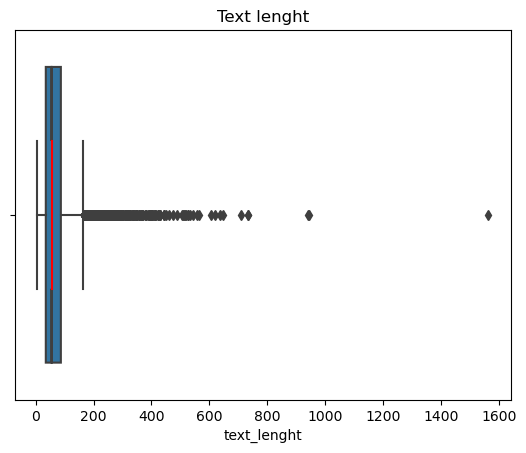

In [39]:
#analysis : lenght,pos ditribution, most used words/tags, number of tags
df["text_lenght"] = df["lemmatized_text"].apply(lambda x: len(x))
boxplot = sns.boxplot(data=df, x="text_lenght", notch=True, medianprops={"color": "red"})
boxplot.set(title='Text lenght')
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  8533  individuals and  21  variables.


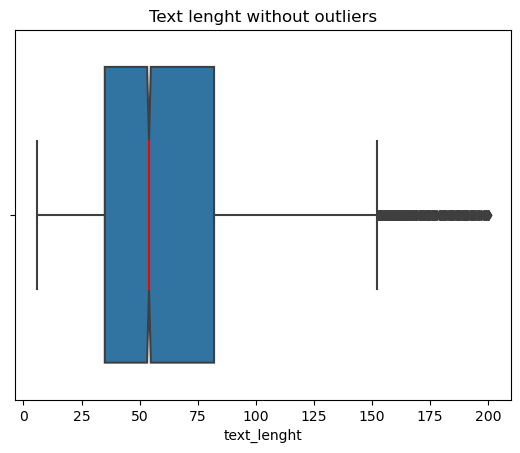

In [40]:
#Dropping outliers
df = df[(df["text_lenght"] <= 200)]

boxplot = sns.boxplot(data=df, x="text_lenght", notch=True, medianprops={"color": "red"})
boxplot.set(title='Text lenght without outliers')
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

C:\Users\alexh\AppData\Local\Temp\ipykernel_11500\1642740785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tag_number"] = df["Tags_cleaned"].apply(lambda x: len(x))


[Text(0.5, 1.0, 'Tag number')]

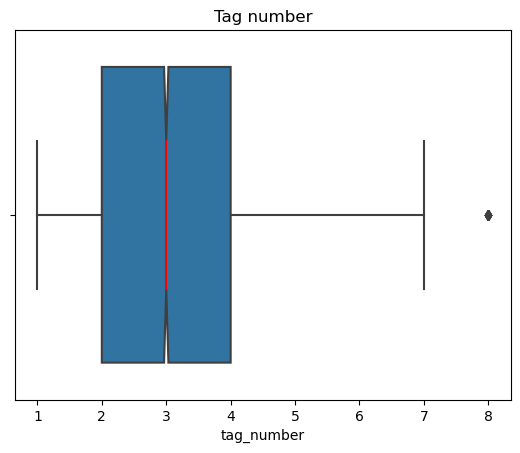

In [41]:
df["tag_number"] = df["Tags_cleaned"].apply(lambda x: len(x))
boxplot = sns.boxplot(data=df, x="tag_number", notch=True, medianprops={"color": "red"})
boxplot.set(title='Tag number')

Dataset has  8520  individuals and  22  variables.


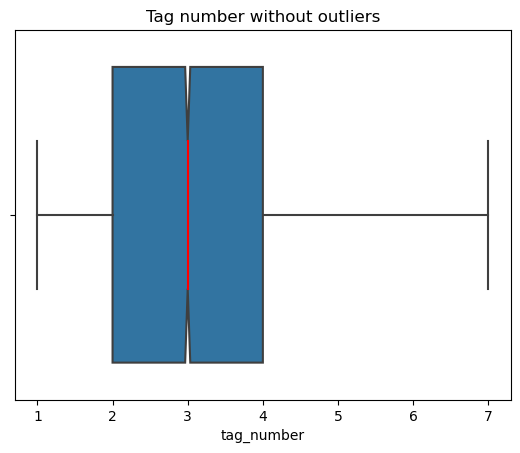

In [42]:
#Dropping outliers
df = df[(df["tag_number"] <= 7)]

boxplot = sns.boxplot(data=df, x="tag_number", notch=True, medianprops={"color": "red"})
boxplot.set(title='Tag number without outliers')
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

[Text(0.5, 1.0, 'Words type distribution')]

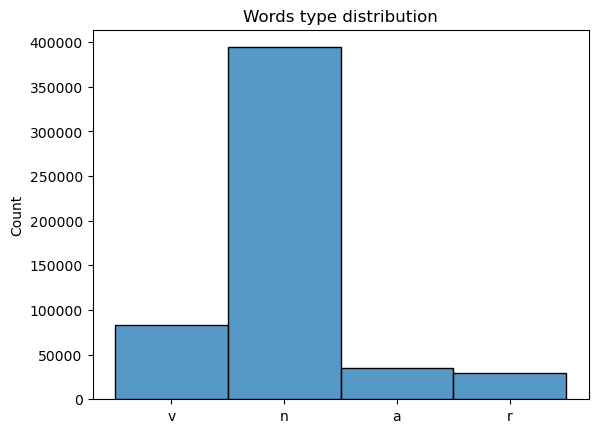

In [43]:
histplot = sns.histplot(data=np.hstack(df["pos_text"]))
histplot.set(title='Words type distribution')

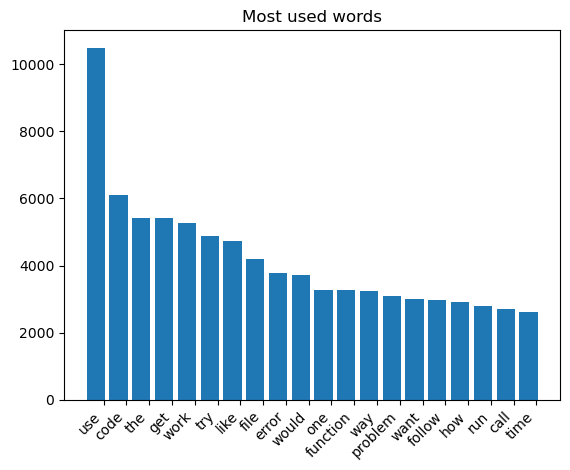

In [44]:
#Display most used words in corpus :

counts = dict(Counter(dictionary_list).most_common(20))
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.xticks(rotation=45,horizontalalignment='right')
plt.title("Most used words")
plt.show()

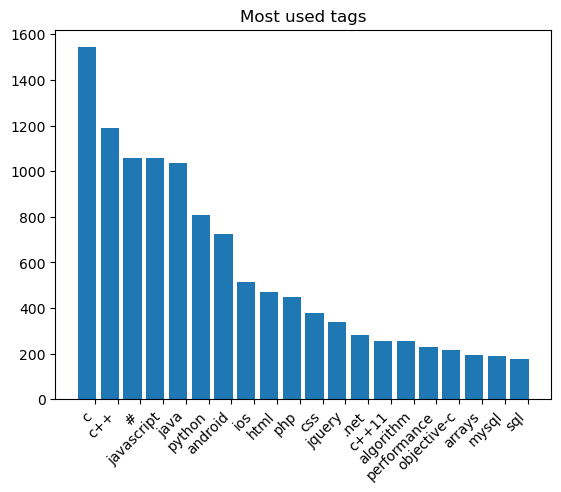

In [45]:
#Display most used tags :

counts = dict(Counter(tags_list).most_common(20))
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.xticks(rotation=45,horizontalalignment='right')
plt.title("Most used tags")
plt.show()

In [46]:
#saving datasets    
df.to_pickle(os.path.join(PATH, "cleaned_data.pkl"))